Analysis of Bike Sharing data from CapitalShare in Washington from January 2011 to December 2012

In [1]:
! pip install pmdarima

In [3]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind


In [5]:
df_hour = pd.read_csv("hour.csv")
df_hour.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Data Structure : 
 hour.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
	- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    - hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	

In [7]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [9]:
# get the transpose of the describe table for numeriacl data
df_hour.describe().T

count         mean          std   min        25%        50%  \
instant     17379.0  8690.000000  5017.029500  1.00  4345.5000  8690.0000   
season      17379.0     2.501640     1.106918  1.00     2.0000     3.0000   
yr          17379.0     0.502561     0.500008  0.00     0.0000     1.0000   
mnth        17379.0     6.537775     3.438776  1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405  0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165  0.00     0.0000     0.0000   
weekday     17379.0     3.003683     2.005771  0.00     1.0000     3.0000   
workingday  17379.0     0.682721     0.465431  0.00     0.0000     1.0000   
weathersit  17379.0     1.425283     0.639357  1.00     1.0000     1.0000   
temp        17379.0     0.496987     0.192556  0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850  0.00     0.3333     0.4848   
hum         17379.0     0.627229     0.192930  0.00     0.4800     0.6300   
windspeed   17379.0     0.190098     0.122340  0.00     0.1045     0.1940   
casual      17379.0    35.676218    49.305030  0.00     4.0000    17.0000   
registered  17379.0   153.786869   151.357286  0.00    34.0000   115.0000   
cnt         17379.0   189.463088   181.387599  1.00    40.0000   142.0000   

                   75%         max  
instant     13034.5000  17379.0000  
season          3.0000      4.0000  
yr              1.0000      1.0000  
mnth           10.0000     12.0000  
hr             18.0000     23.0000  
holiday         0.0000      1.0000  
weekday         5.0000      6.0000  
workingday      1.0000      1.0000  
weathersit      2.0000      4.0000  
temp            0.6600      1.0000  
atemp           0.6212      1.0000  
hum             0.7800      1.0000  
windspeed       0.2537      0.8507  
casual         48.0000    367.0000  
registered    220.0000    886.0000  
cnt           281.0000    977.0000

Divide the data into sub-data:
- Temporal Features: columns related to the time, including : dteday, season, yr, mnth, hr, holiday, weekday, and workingday columns.
- Weather Features: This contains information about the weather conditions. The weathersit, temp, atemp, hum, and windspeed columns are included in this group.
- Record Feature: This contains information about the number of records for the specific hour and date. This group includes the casual, registered, and cnt columns.

### Data Preprocessing & Wrangling

In [13]:
# change data to make it more human_readeable
hourly_data = df_hour.copy()
season = {1:"winter", 2:"spring", 3:"summer", 4:"fall"}
year = {0 : 2011, 1:2012}
month = {1: 'January', 2: 'February',3:'March', 4:'April', 5:'May', 6:'June',7:'July',
         8:'August',9:'September',10:'October',11:'November',12:'December'}
day = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
weather_mapping = {1: 'clear', 2: 'cloudy', 3: 'light_rain_snow', 4: 'heavy_rain_snow'}

hourly_data['season'] = hourly_data['season'].apply(lambda x: season[x])
hourly_data['yr'] = hourly_data['yr'].apply(lambda x: year[x])
hourly_data['mnth'] = hourly_data['mnth'].apply(lambda x: month[x])
hourly_data['weekday'] = hourly_data['weekday'].apply(lambda x: day[x])
hourly_data['weathersit'] = hourly_data['weathersit'].apply(lambda x :  weather_mapping[x])

# transform the humudity and windspeed since they are normalized, this make them more human readable
# temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
# atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)



hourly_data['hum'] = hourly_data['hum']*100
hourly_data['windspeed'] = hourly_data['windspeed']*67
hourly_data['temp'] = hourly_data['temp']*(39 + 8) - 8 
hourly_data['atemp'] = hourly_data['atemp']*(50 + 16) - 16 



hourly_data.head()

instant      dteday  season    yr     mnth  hr  holiday   weekday  \
0        1  2011-01-01  winter  2011  January   0        0  Saturday   
1        2  2011-01-01  winter  2011  January   1        0  Saturday   
2        3  2011-01-01  winter  2011  January   2        0  Saturday   
3        4  2011-01-01  winter  2011  January   3        0  Saturday   
4        5  2011-01-01  winter  2011  January   4        0  Saturday   

   workingday weathersit  temp   atemp   hum  windspeed  casual  registered  \
0           0      clear  3.28  3.0014  81.0        0.0       3          13   
1           0      clear  2.34  1.9982  80.0        0.0       8          32   
2           0      clear  2.34  1.9982  80.0        0.0       5          27   
3           0      clear  3.28  3.0014  75.0        0.0       3          10   
4           0      clear  3.28  3.0014  75.0        0.0       0           1   

   cnt  
0   16  
1   40  
2   32  
3   13  
4    1

In [15]:
# check cnt = casual + registered

assert (hourly_data.casual + hourly_data.registered == hourly_data.cnt).all()

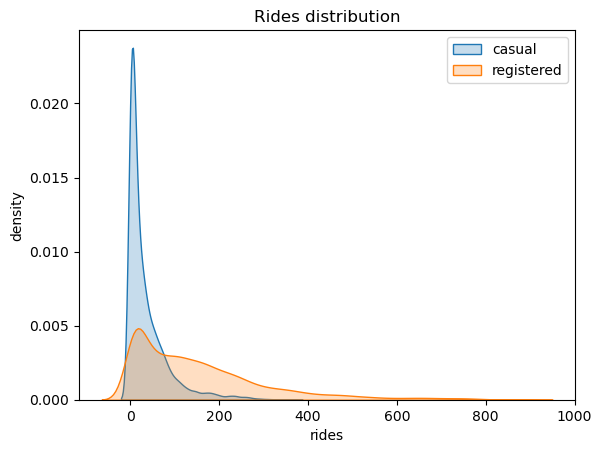

In [17]:
# casual and registered coulmns, first look at their distribution
sns.kdeplot(hourly_data.casual, label = 'casual',fill = True)
sns.kdeplot(hourly_data.registered, label = 'registered', fill = True)
plt.legend()
plt.xlabel('rides')
plt.ylabel('density')
plt.title('Rides distribution')
plt.show()

- Registered users perform more rides than casual users.
- Both distributions are skewed to the right, meaning that for most of the data entries, users have zero or a small number of rides.
- There are times in the study when we have more than 600 registered rides. 

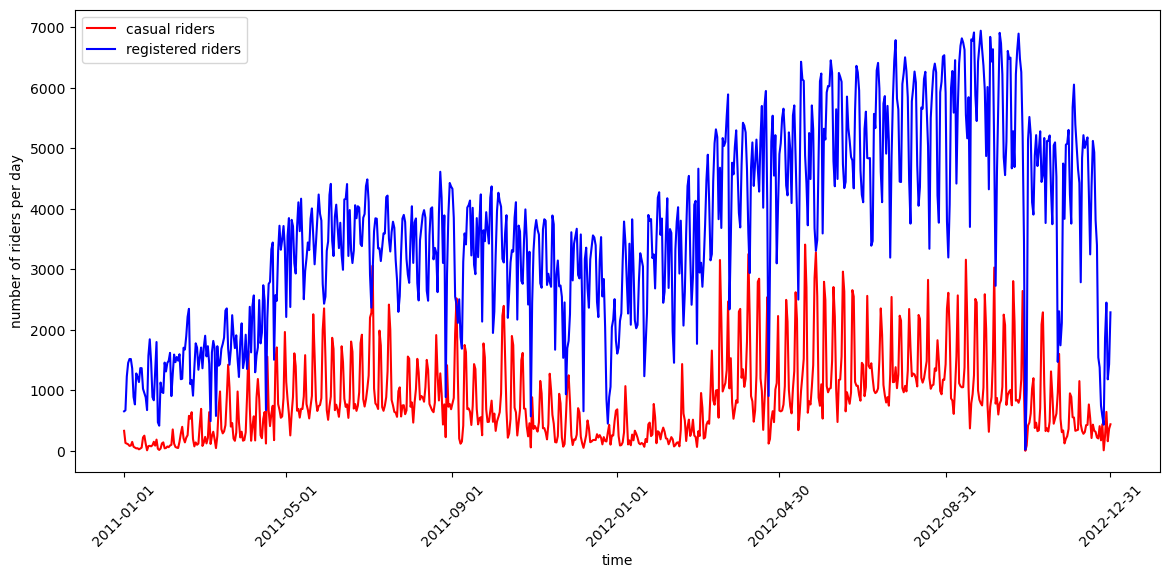

In [20]:
time_series_plot = hourly_data[['dteday', 'casual','registered']].groupby('dteday').sum()
plt.figure(figsize = (14,6))
plt.plot(time_series_plot.index, time_series_plot['casual'],  label = 'casual riders', color = 'r')
plt.plot(time_series_plot.index, time_series_plot['registered'], label = 'registered riders', color = 'b')
plt.xlabel('time')
plt.ylabel('number of riders per day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=4))
plt.legend()
plt.show()

The number of registered rides are significantly higher than the casual rides. Also, the number of rides decrease noticably during winter. 
There is quite a lot of variance in the time series of the rides . One way to smooth out the curves is to take the rolling mean and standard deviation of the two time series and plot those instead.


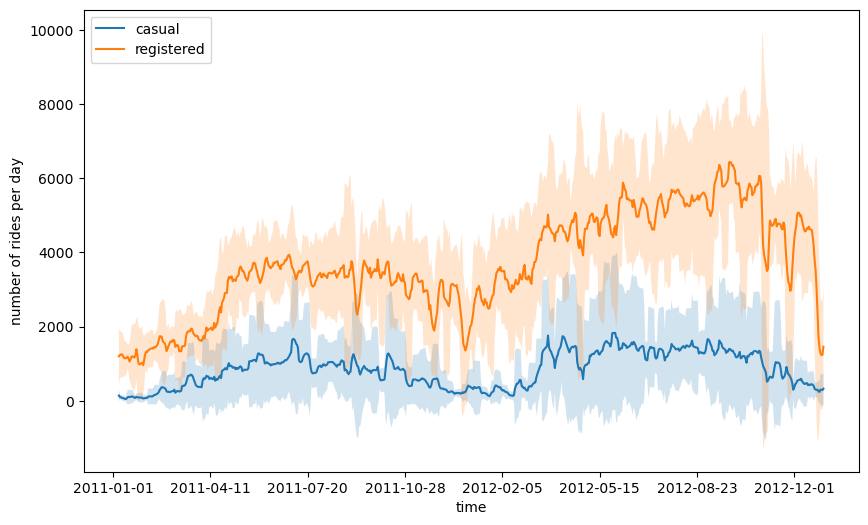

In [23]:
# Plot rolling mean and std

weekly_mean = time_series_plot.rolling(7).mean()
weekly_std = time_series_plot.rolling(7).std()
ax = weekly_mean.plot(figsize=(10,6))

ax.fill_between(weekly_mean.index, 
                weekly_mean['casual'] + 2*weekly_std['casual'], 
                weekly_mean['casual'] - 2*weekly_std['casual'], 
                alpha = 0.2)

ax.fill_between(weekly_mean.index, 
                weekly_mean['registered'] + 2*weekly_std['registered'],
                weekly_mean['registered'] - 2*weekly_std['registered'], 
                alpha = 0.2)

ax.set_xlabel("time");
ax.set_ylabel("number of rides per day")
plt.show()

###  Analyzing Daily Impact on Rides

In [26]:
""" melt() function, applied on a pandas dataset. It will create a new 
dataset, in which values are grouped by the hr and weekday columns, while creating 
two new columns: type (containing the casual and registered values) and 
count (containing the respective counts for the casual and registered types)."""

hour_week_data = hourly_data[['hr', 'weekday', 'registered', 'casual']]
plot_data = hour_week_data.melt(id_vars=['hr', 'weekday'], var_name='type', value_name='count')
plot_data.head(5), plot_data.tail(5)

(   hr   weekday        type  count
 0   0  Saturday  registered     13
 1   1  Saturday  registered     32
 2   2  Saturday  registered     27
 3   3  Saturday  registered     10
 4   4  Saturday  registered      1,
        hr weekday    type  count
 34753  19  Monday  casual     11
 34754  20  Monday  casual      8
 34755  21  Monday  casual      7
 34756  22  Monday  casual     13
 34757  23  Monday  casual     12)

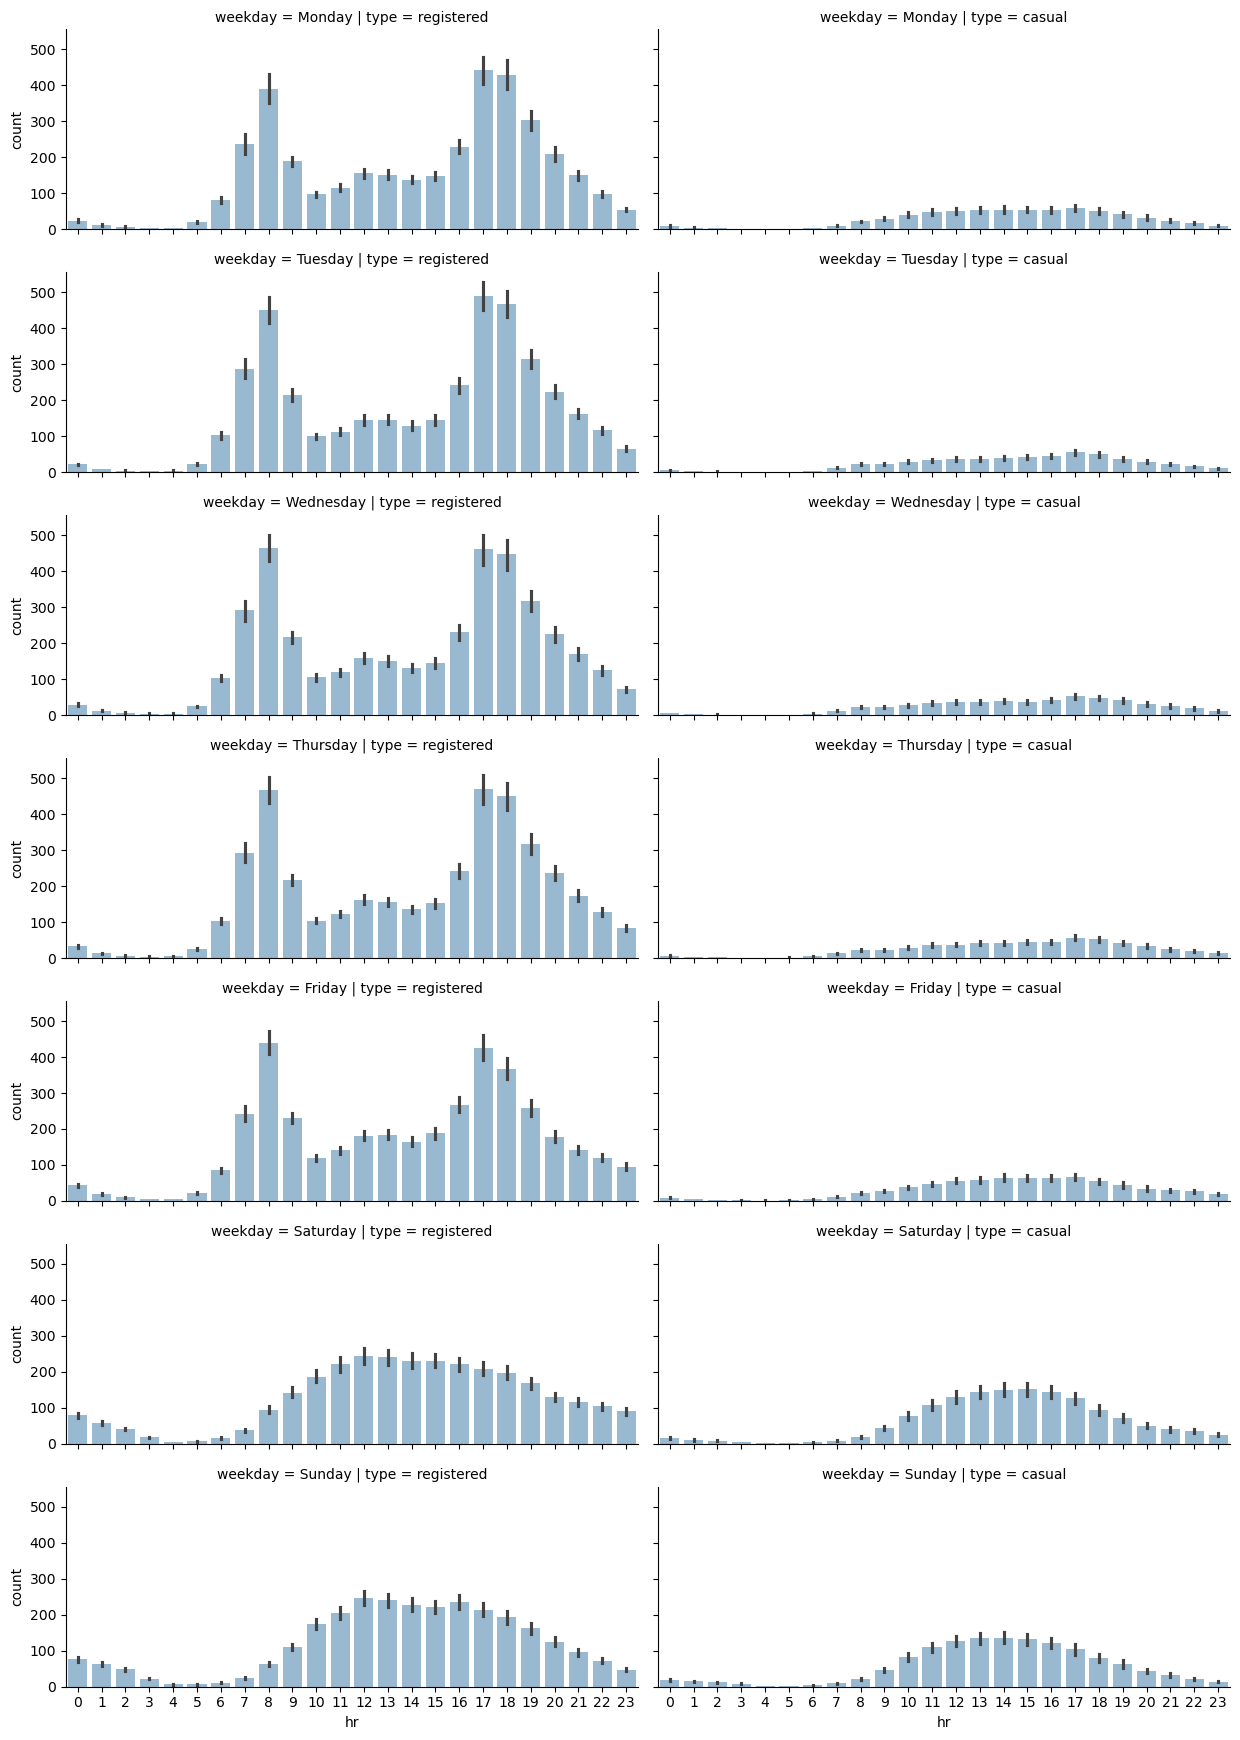

In [28]:
grid = sns.FacetGrid(plot_data, row='weekday', col='type', height=2.5,
                     aspect=2.5, row_order=['Monday', 'Tuesday', 
                                            'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
hr_order = plot_data['hr'].unique()
grid.map(sns.barplot, 'hr', 'count', alpha=0.5, order=hr_order)


- On working days, the highest number of rides for registered users takes place around 8 AM and at 6 PM. 
- On the other hand, the casual usage of bike sharing services on working days is quite limited.
- During the weekend, we can see that ride distributions change for both casual and registered users. Still, registered rides are more frequent than casual ones, but both the distributions have the same shape, almost uniformly distributed between the time interval of 11 AM to 6 PM.

In [30]:
hourly_data.head()

instant      dteday  season    yr     mnth  hr  holiday   weekday  \
0        1  2011-01-01  winter  2011  January   0        0  Saturday   
1        2  2011-01-01  winter  2011  January   1        0  Saturday   
2        3  2011-01-01  winter  2011  January   2        0  Saturday   
3        4  2011-01-01  winter  2011  January   3        0  Saturday   
4        5  2011-01-01  winter  2011  January   4        0  Saturday   

   workingday weathersit  temp   atemp   hum  windspeed  casual  registered  \
0           0      clear  3.28  3.0014  81.0        0.0       3          13   
1           0      clear  2.34  1.9982  80.0        0.0       8          32   
2           0      clear  2.34  1.9982  80.0        0.0       5          27   
3           0      clear  3.28  3.0014  75.0        0.0       3          10   
4           0      clear  3.28  3.0014  75.0        0.0       0           1   

   cnt  
0   16  
1   40  
2   32  
3   13  
4    1

### Analyzing Seasonal Impact on Rides

C:\Users\samir\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


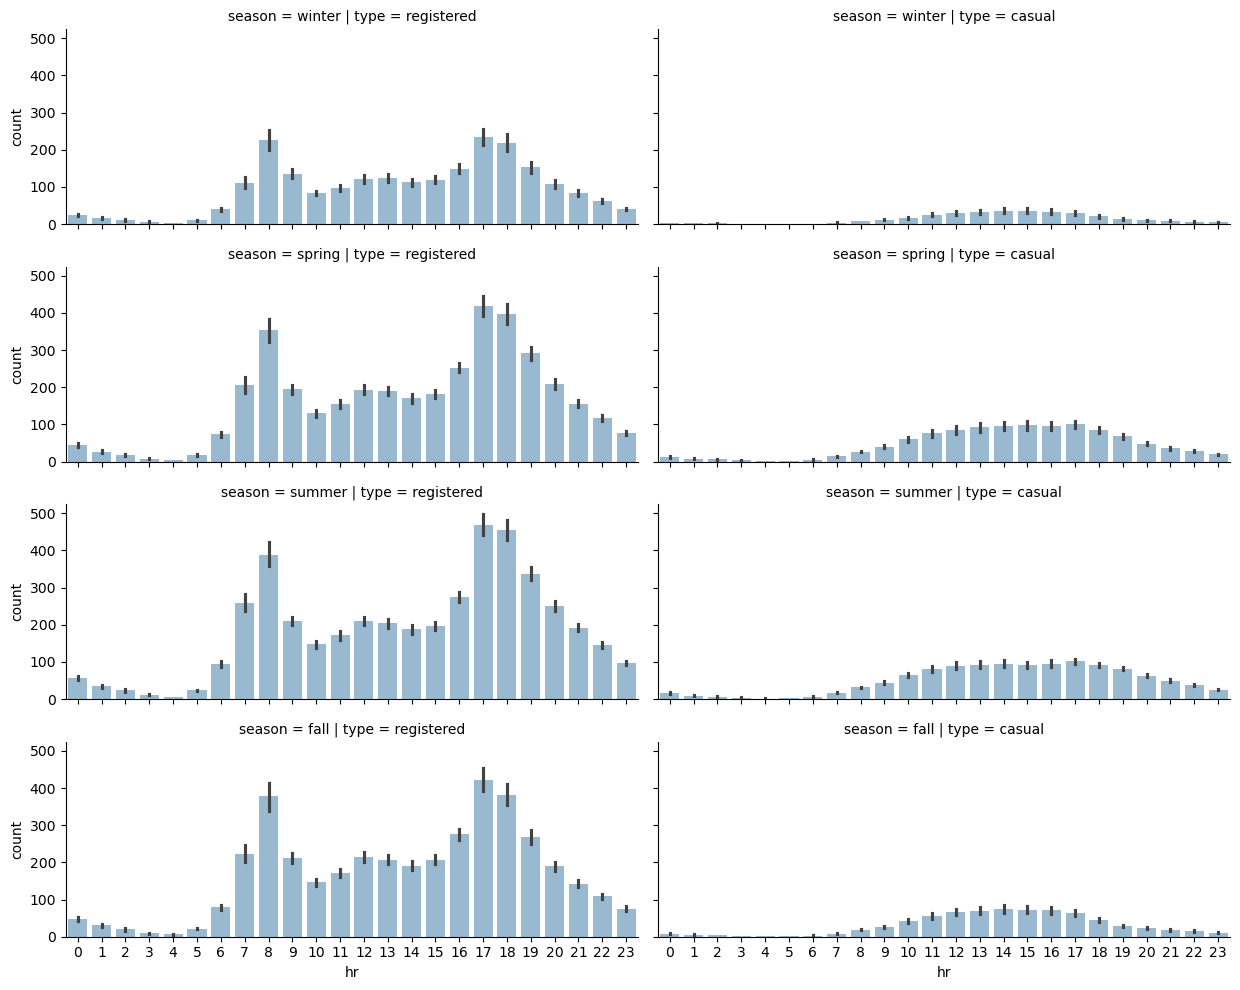

In [32]:
# select subset of the data
plot_data = hourly_data[['hr', 'season', 'registered', 'casual']]

# unpivot data from wide to long format
plot_data = plot_data.melt(id_vars=['hr', 'season'], var_name='type', \
                           value_name='count')

# define FacetGrid
grid = sns.FacetGrid(plot_data, row='season', \
                     col='type', height=2.5, aspect=2.5, \
                     row_order=['winter', 'spring', 'summer', 'fall'])

# apply plotting function to each element in the grid
grid.map(sns.barplot, 'hr', 'count', alpha=0.5)

As can be seen in the plot, while each season has a similar graph shape, the count is lower for the winter graph. So there are fewer rides (registered and casual) during winter.

C:\Users\samir\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


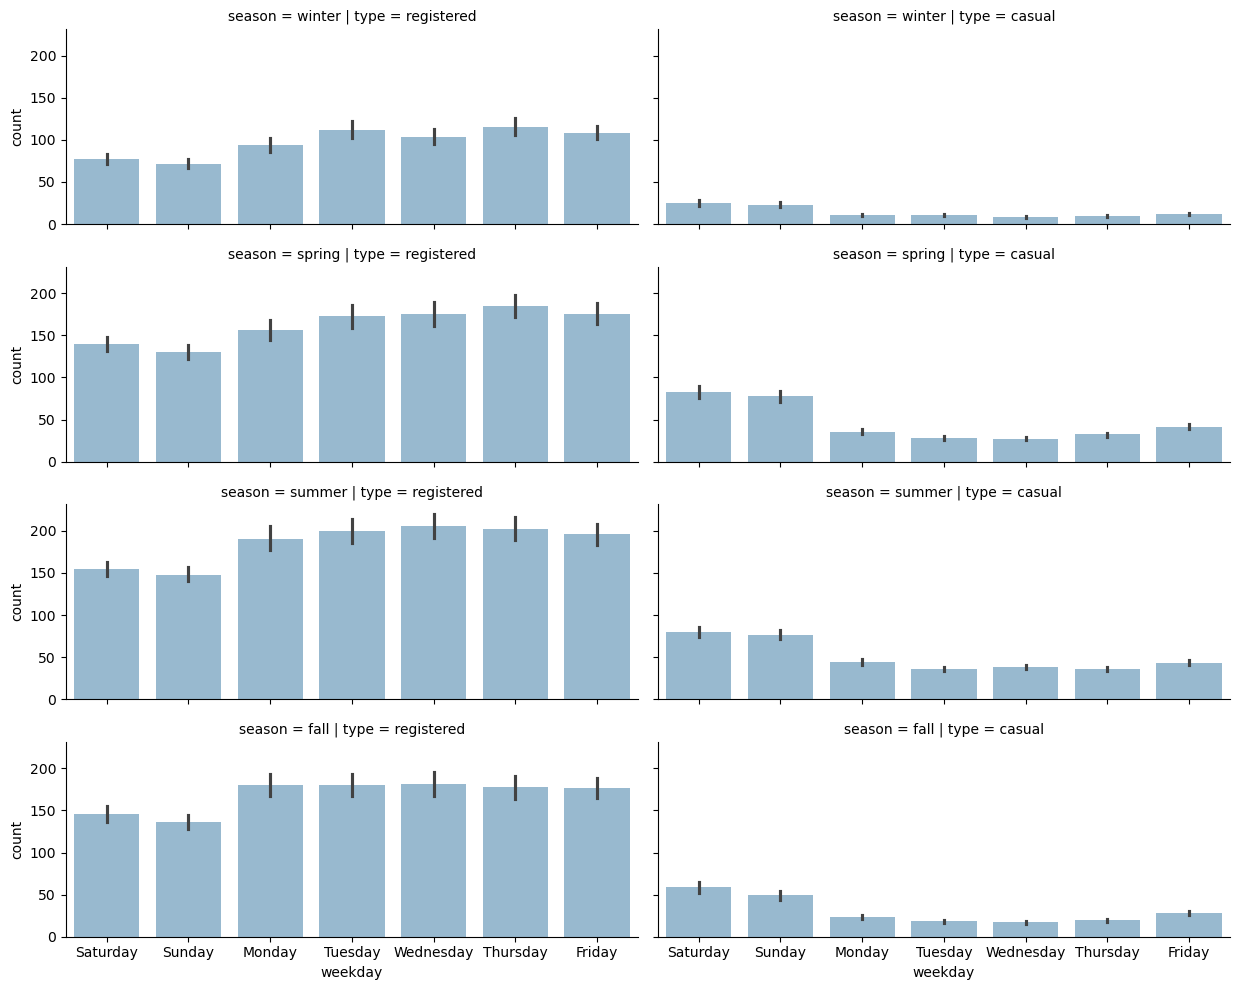

In [34]:
# select subset of the data
plot_data = hourly_data[['weekday', 'season', 'registered', 'casual']]

# unpivot data from wide to long format
plot_data = plot_data.melt(id_vars=['weekday', 'season'], var_name='type', \
                           value_name='count')

# define FacetGrid
grid = sns.FacetGrid(plot_data, row='season', \
                     col='type', height=2.5, aspect=2.5, \
                     row_order=['winter', 'spring', 'summer', 'fall'])

# apply plotting function to each element in the grid
grid.map(sns.barplot, 'weekday', 'count', alpha=0.5)

There is a decreasing number of registered rides over the weekend (compared to the rest of the week), while the number of casual rides 
increases. This could enforce our initial hypothesis, that is, that registered customers mostly use the bike sharing service for commuting (which could be the reason for the 
decreasing number of registered rides over the weekend), while casual customers use the service occasionally over the weekend. Of course, such a conclusion cannot 
be based solely on plot observations but has to be backed by statistical tests, which is the topic of our next section.

"If we want to perform hypothesis testing and have the entire population data, we usually don't need to sample, as we already know the population mean. However, if we simulate a scenario where we only have a sample, we randomly select a sample from the population and calculate its mean. The null hypothesis is that the sample mean equals the population mean. If the sample size is greater than 30, we can rely on the Central Limit Theorem to assume the sampling distribution of the sample mean approximates a normal distribution, even if the population is not normally distributed."

### Hypothesis Testing on Registered Rides

- H_0 : average registered rides over weekdays-average registered rides over weekend=0
- H_a : average registered rides over weekdays-average registered rides over weekend≠0

In [39]:
hourly_data.head(3)

instant      dteday  season    yr     mnth  hr  holiday   weekday  \
0        1  2011-01-01  winter  2011  January   0        0  Saturday   
1        2  2011-01-01  winter  2011  January   1        0  Saturday   
2        3  2011-01-01  winter  2011  January   2        0  Saturday   

   workingday weathersit  temp   atemp   hum  windspeed  casual  registered  \
0           0      clear  3.28  3.0014  81.0        0.0       3          13   
1           0      clear  2.34  1.9982  80.0        0.0       8          32   
2           0      clear  2.34  1.9982  80.0        0.0       5          27   

   cnt  
0   16  
1   40  
2   32

In [40]:
weekend_data = hourly_data["registered"][hourly_data["workingday"] == 0]
work_data = hourly_data["registered"][hourly_data["workingday"] == 1]

print(f"the average of registered bike rides during weekend is {round(weekend_data.mean(),2)} while for working days is {round(work_data.mean(),2)}")

the average of registered bike rides during weekend is 123.96 while for working days is 167.65


In [41]:
# perform ttest
from scipy.stats import ttest_ind
test_res = ttest_ind(weekend_data, work_data)
print(f"Statistic value: {test_res[0]:.03f}, p-value: {test_res[1]:.03f}")

Statistic value: -17.869, p-value: 0.000


The resulting p-value from this test is less than 0.0001, which is far below the standard critical 0.05 value. As a conclusion, we can reject the null hypothesis and confirm that our initial observation is correct: that is, there is a statistically significant difference between the number of rides performed during working days and the weekend.

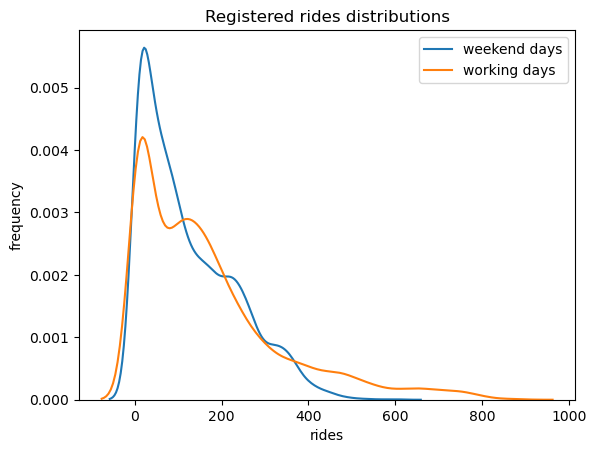

In [43]:
sns.kdeplot(weekend_data, label='weekend days')
sns.kdeplot(work_data, label='working days')
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title("Registered rides distributions");

### Hypothesis Testing on Casual Rides

the average of casual bike rides during weekend is 57.44 while for working days is 25.56
Statistic value: 41.599, p-value: 0.000


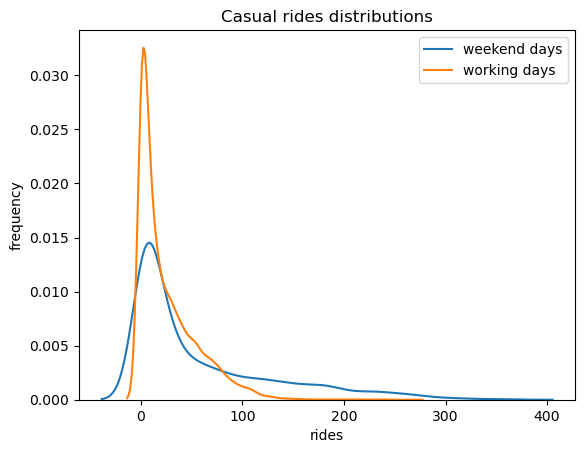

In [47]:
weekend_data_casual = hourly_data["casual"][hourly_data["workingday"] == 0]
work_data_casual = hourly_data["casual"][hourly_data["workingday"] == 1]

print(f"the average of casual bike rides during weekend is {round(weekend_data_casual.mean(),2)} while for working days is {round(work_data_casual.mean(),2)}")

test_res = ttest_ind(weekend_data_casual, work_data_casual)
print(f"Statistic value: {test_res[0]:.03f}, p-value: {test_res[1]:.03f}")

sns.kdeplot(weekend_data_casual, label='weekend days')
sns.kdeplot(work_data_casual, label='working days')
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title("Casual rides distributions");

### Correlation of weather related columns and casual & registered columns

In [49]:
def plot_correlations(data, col):
    # get correlation between col and registered rides
    corr_r = np.corrcoef(hourly_data[col], hourly_data["registered"])[0,1]
    ax = sns.regplot(x=col, y="registered", data=data,scatter_kws={"alpha":0.05}, label=f"Registered rides (correlation: {corr_r:.3f})")
    # get correlation between col and casual rides
    corr_c = np.corrcoef(hourly_data[col], hourly_data["casual"])[0,1]
    ax = sns.regplot(x=col, y='casual', data=data, scatter_kws={"alpha":0.05},label=f"Casual rides (correlation: {corr_c:.3f})")
    #adjust legend alpha
    legend = ax.legend()
    for lh in legend.get_patches():  # Access legend handles
        lh.set_alpha(0.5)  # Adjust transparency
        ax.set_ylabel("rides")
        ax.set_title(f"Correlation between rides and {col}")
        return ax

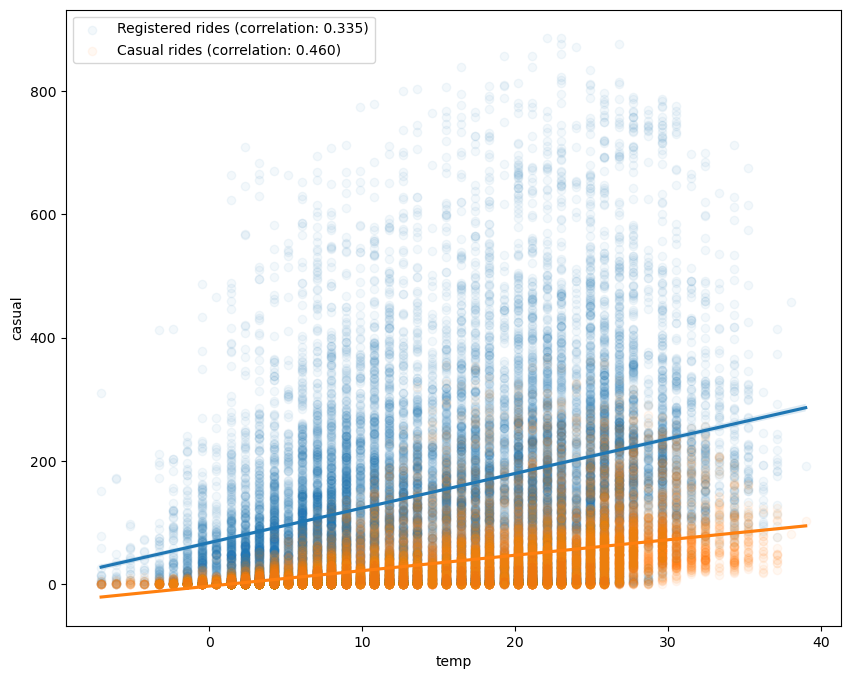

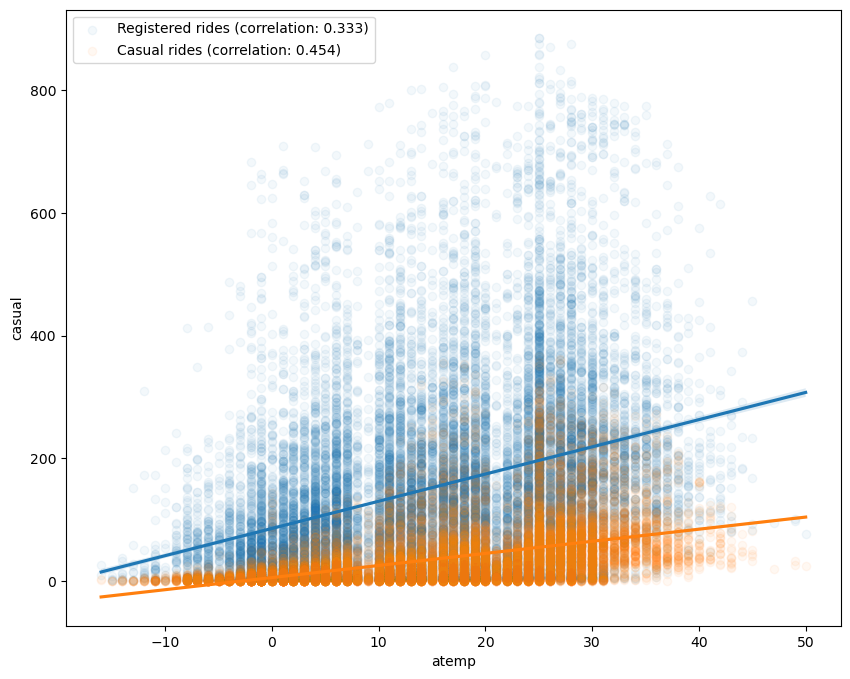

In [50]:
plt.figure(figsize=(10,8))
ax = plot_correlations(hourly_data, 'temp')
plt.figure(figsize=(10,8))
ax = plot_correlations(hourly_data, 'atemp')

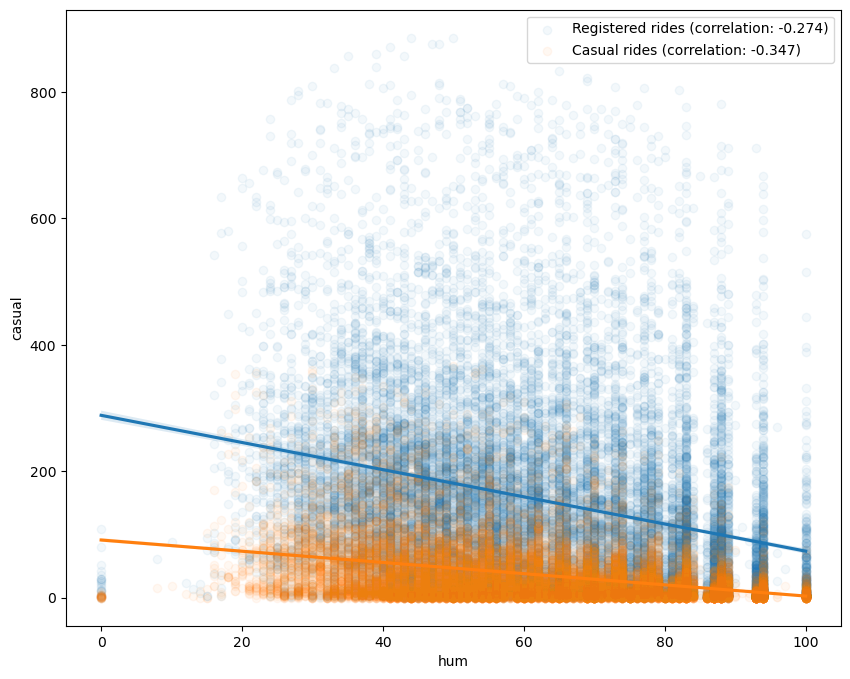

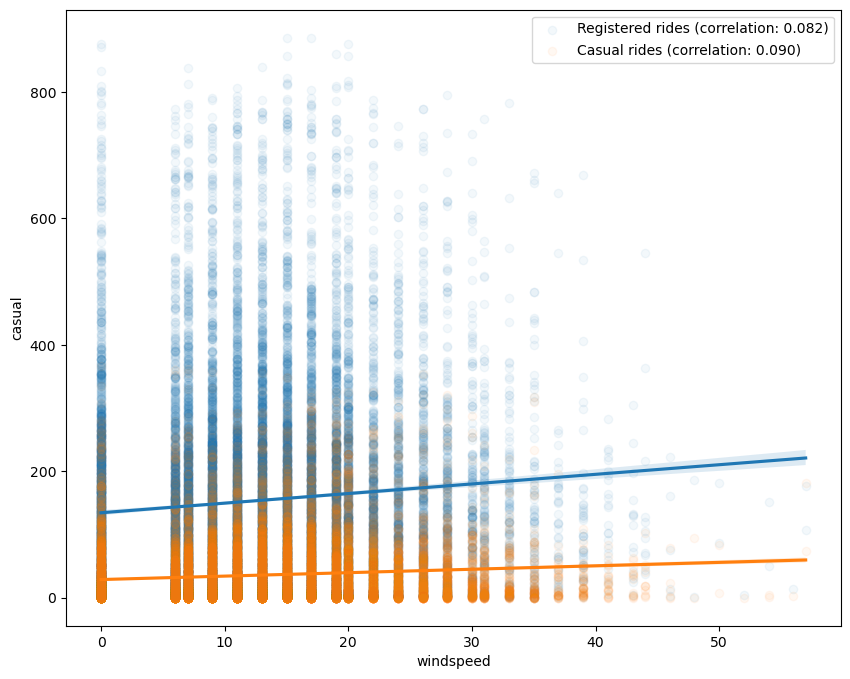

In [51]:
plt.figure(figsize=(10,8))
ax = plot_correlations(hourly_data, 'hum')
plt.figure(figsize=(10,8))
ax = plot_correlations(hourly_data, 'windspeed')

we can observe that higher temperatures have a positive impact on the number of rides (the correlation between registered/casual rides and temp is
0.335 and 0.46, respectively, and it's a similar case for atemp). Note that as the values in the registered column are widely spread with respect to the different values in temp, we have a lower correlation compared to the casual column. 
the humidity level has a negative correlation with both types of rides (-0.274 for registered and -0.347 for casual). This means that with a high level of humidity (mist or rain), customers will tend not to use the bike sharing service. We can see that there is minimal correlation between the number of rides and the wind speed (a weak positive correlation).

In [53]:
hourly_data.head(3)

instant      dteday  season    yr     mnth  hr  holiday   weekday  \
0        1  2011-01-01  winter  2011  January   0        0  Saturday   
1        2  2011-01-01  winter  2011  January   1        0  Saturday   
2        3  2011-01-01  winter  2011  January   2        0  Saturday   

   workingday weathersit  temp   atemp   hum  windspeed  casual  registered  \
0           0      clear  3.28  3.0014  81.0        0.0       3          13   
1           0      clear  2.34  1.9982  80.0        0.0       8          32   
2           0      clear  2.34  1.9982  80.0        0.0       5          27   

   cnt  
0   16  
1   40  
2   32

<Axes: title={'center': 'windspeed | cloudy'}>

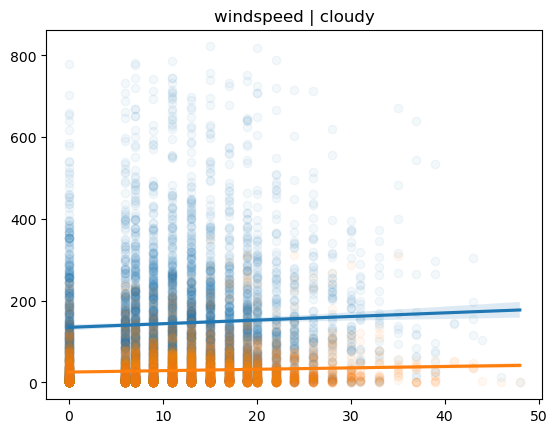

In [54]:
def weathersit(hourly_data, col, cond):
    data = hourly_data[hourly_data["weathersit"] == cond]
    # create regplot for registered users
    ax = sns.regplot(x = col, y = "registered", data = data, scatter_kws={"alpha":0.05})
    
    # create regplot for casual users
    ax = sns.regplot(x=col, y="casual", data = data , scatter_kws={"alpha":0.05})
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{col} | {cond}")
    return ax

weathersit(hourly_data, "windspeed", "cloudy")   

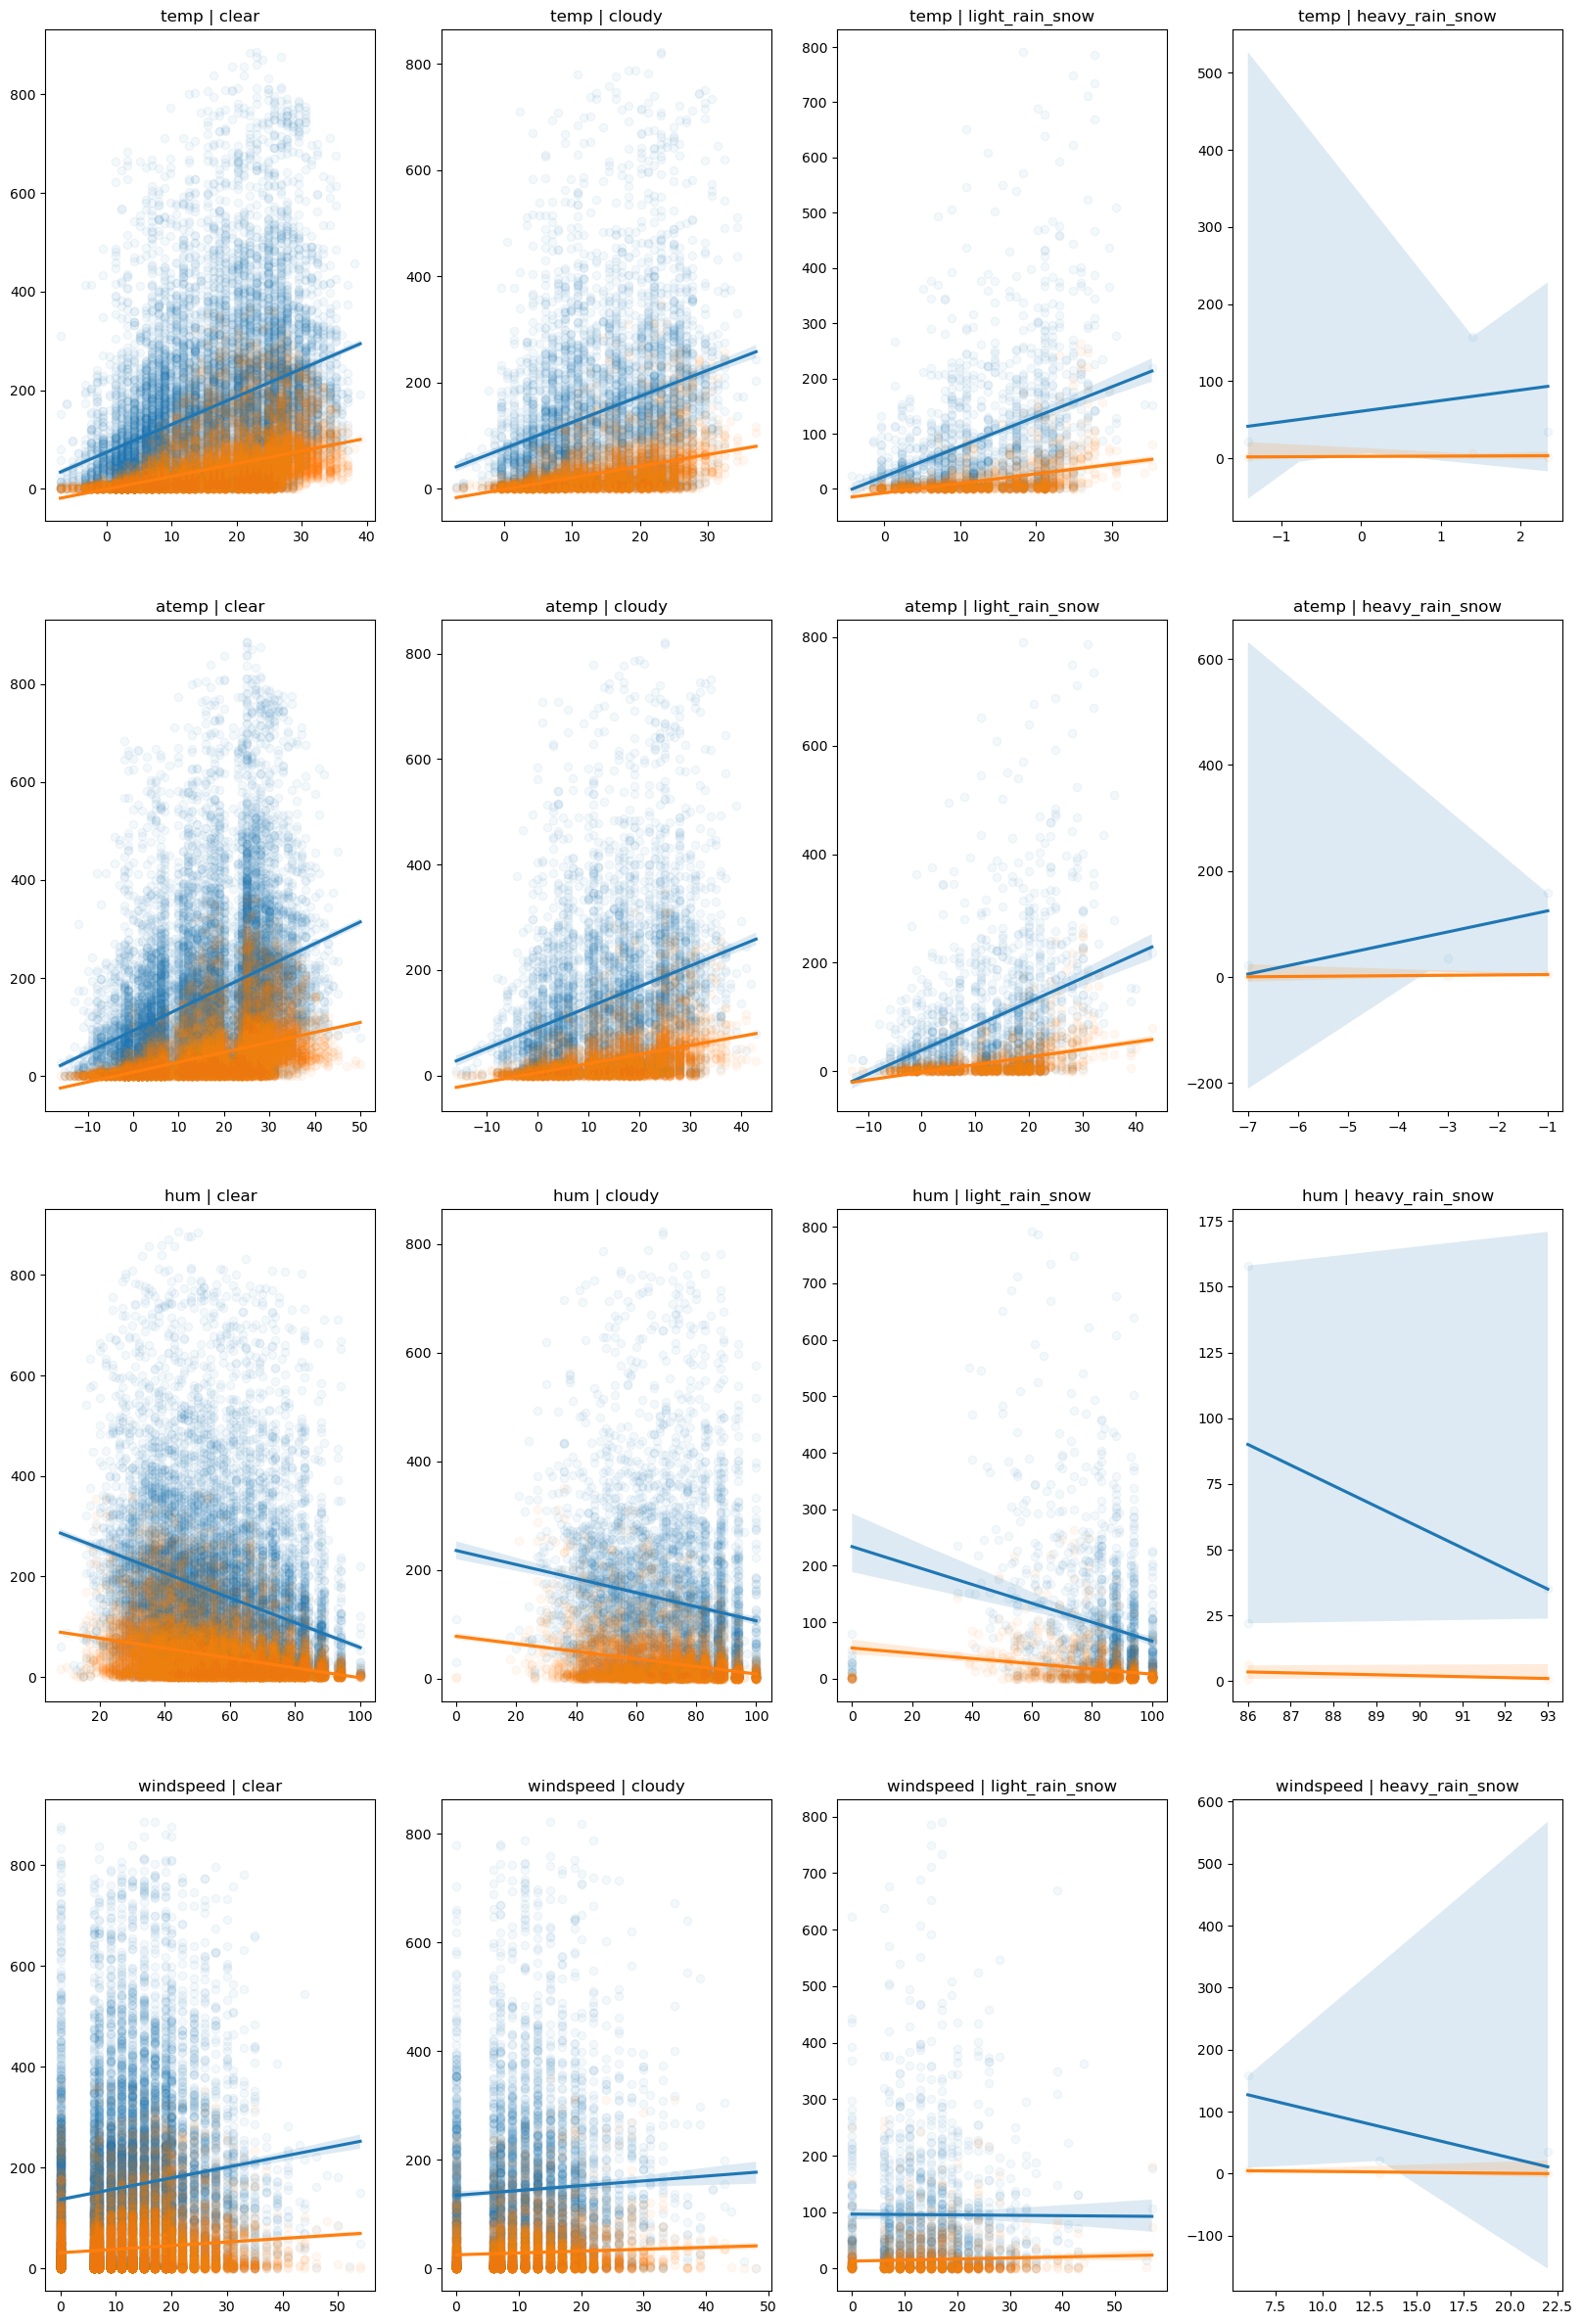

In [55]:
def weathersit(hourly_data, col, cond):
    data = hourly_data[hourly_data["weathersit"] == cond]
    # create regplot for registered users
    ax = sns.regplot(x = col, y = "registered", data = data, scatter_kws={"alpha":0.05})
    
    # create regplot for casual users
    ax = sns.regplot(x=col, y="casual", data = data , scatter_kws={"alpha":0.05})
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{col} | {cond}")
    return ax


weather_conditions = hourly_data.weathersit.unique()
columns = ["temp", "atemp", "hum", "windspeed"]

plt.figure(figsize=(20,30))
for col_index, col in enumerate(columns):
    for row_index, weather_cond in enumerate(weather_conditions):
        plot_number = row_index + col_index * 4 + 1
        plt.subplot(4,4,plot_number)
        weathersit(hourly_data, col, weather_cond)   

### Evaluating the Difference between the Pearson and Spearman Correlations

In [58]:
def compute_correlations(data, col):
    pearson_reg = pearsonr(data[col], data["registered"])[0]
    pearson_cas = pearsonr(data[col], data["casual"])[0]
    spearman_reg = spearmanr(data[col], data["registered"])[0]
    spearman_cas = spearmanr(data[col], data["casual"])[0]
    return pd.Series({"Pearson (registered)": pearson_reg,
                    "Spearman (registered)": spearman_reg,
                    "Pearson (casual)": pearson_cas,
                    "Spearman (casual)": spearman_cas})

In [59]:
# compute correlation measures between different features
cols = ["temp", "atemp", "hum", "windspeed"]
corr_data = pd.DataFrame(index=["Pearson (registered)", "Spearman (registered)","Pearson (casual)", "Spearman (casual)"])
for col in cols:
    corr_data[col]=compute_correlations(hourly_data, col)
corr_data.T

Pearson (registered)  Spearman (registered)  Pearson (casual)  \
temp                   0.335361               0.373196          0.459616   
atemp                  0.332559               0.373014          0.454080   
hum                   -0.273933              -0.338480         -0.347028   
windspeed              0.082321               0.122936          0.090287   

           Spearman (casual)  
temp                0.570989  
atemp               0.570419  
hum                -0.388213  
windspeed           0.122920

As we can observe, for most of the variables, the Pearson and Spearman correlation coefficient are close enough (some non-linearity is to be expected). The most striking difference between the two coefficients occurs when comparing the temp (and atemp) and casual columns. More precisely, the Spearman correlation is quite high, meaning that there is significant evidence for a nonlinear, relatively strong and positive relationship.
An interpretation of this result is that casual customers are far keener on using the bike sharing service when temperatures are higher. We have already seen from our previous analysis that casual customers ride mostly during the weekend, and they do not rely on bike sharing services for commuting to work. This conclusion is again confirmed by the strong relationship with temperature, as opposed to registered customers, whose rides have a weaker correlation with temperature.

(5.5, -0.5)

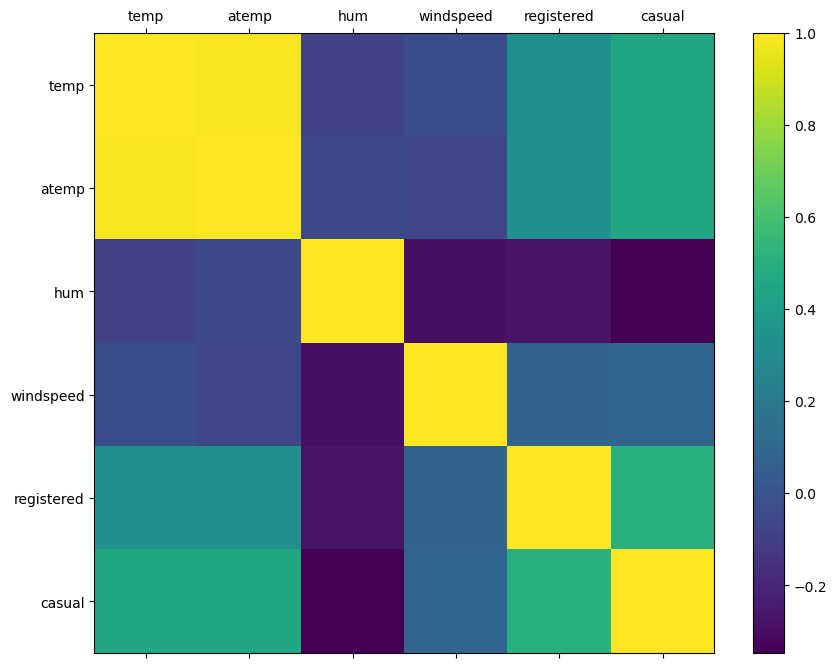

In [61]:
# plot correlation matrix
cols = ["temp", "atemp", "hum", "windspeed", "registered", "casual"]
plot_data = hourly_data[cols]
corr = plot_data.corr()
fig = plt.figure(figsize=(10,8))
plt.matshow(corr, fignum=fig.number)
plt.xticks(range(len(plot_data.columns)), plot_data.columns)
plt.yticks(range(len(plot_data.columns)), plot_data.columns)
plt.colorbar()
plt.ylim([5.5, -0.5])


In [62]:
# create function for computing pearson correlation
def print_correlations(data, col, weather_cond):
    # extract data for the specific weather condition
    corr_data = data[data['weathersit'] == weather_cond]
    
    # compute pearson correlation between col and registered rides
    pearson_corr_r = pearsonr(corr_data[col], corr_data["registered"])
    
    # compute pearson correlation between col and registered rides
    pearson_corr_c = pearsonr(corr_data[col], corr_data["casual"])
    
    # print correlations
    print(f"Pearson correlation (registered, {col}): corr={pearson_corr_r[0]:.03f}, pval={pearson_corr_r[1]:.03f}")
    print(f"Pearson correlation (casual, {col}): corr={pearson_corr_c[0]:.03f}, pval={pearson_corr_c[1]:.03f}")

In [72]:
# print correlations for temp, atemp, hum and windspeed columns 
# with registered and casual rides
weather_conditions = df_hour.weathersit.unique()
columns = ["temp", "atemp", "hum", "windspeed"]

for col in columns:
    for weather_cond in weather_conditions:
        print_correlations(df_hour, col, weather_cond)

Pearson correlation (registered, temp): corr=0.340, pval=0.000
Pearson correlation (casual, temp): corr=0.459, pval=0.000
Pearson correlation (registered, temp): corr=0.285, pval=0.000
Pearson correlation (casual, temp): corr=0.437, pval=0.000
Pearson correlation (registered, temp): corr=0.356, pval=0.000
Pearson correlation (casual, temp): corr=0.433, pval=0.000
Pearson correlation (registered, temp): corr=0.360, pval=0.766
Pearson correlation (casual, temp): corr=0.277, pval=0.821
Pearson correlation (registered, atemp): corr=0.334, pval=0.000
Pearson correlation (casual, atemp): corr=0.451, pval=0.000
Pearson correlation (registered, atemp): corr=0.285, pval=0.000
Pearson correlation (casual, atemp): corr=0.434, pval=0.000
Pearson correlation (registered, atemp): corr=0.366, pval=0.000
Pearson correlation (casual, atemp): corr=0.445, pval=0.000
Pearson correlation (registered, atemp): corr=0.810, pval=0.399
Pearson correlation (casual, atemp): corr=0.756, pval=0.454
Pearson correlat

### Time Series Decomposition in Trend, Seasonality,and Residual Components

In [75]:
"""
define function for plotting rolling statistics and ADF test for time
series
"""
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts, window=10, **kwargs):
    # create dataframe for plotting
    plot_data = pd.DataFrame(ts)
    plot_data['rolling_mean'] = ts.rolling(window).mean()
    plot_data['rolling_std'] = ts.rolling(window).std()
    # compute p-value of Dickey-Fuller test
    p_val = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dickey-Fuller p-value: {p_val:.3f}")

# get daily rides
daily_rides = hourly_data[["dteday", "registered", "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()
# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)

In [77]:
# subtract rolling mean
registered = daily_rides["registered"]
registered_ma = registered.rolling(10).mean()


registered_ma_diff = registered - registered_ma
registered_ma_diff.dropna(inplace=True)
casual = daily_rides["casual"]
casual_ma = casual.rolling(10).mean()
casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace=True)

<Figure size 640x480 with 0 Axes>

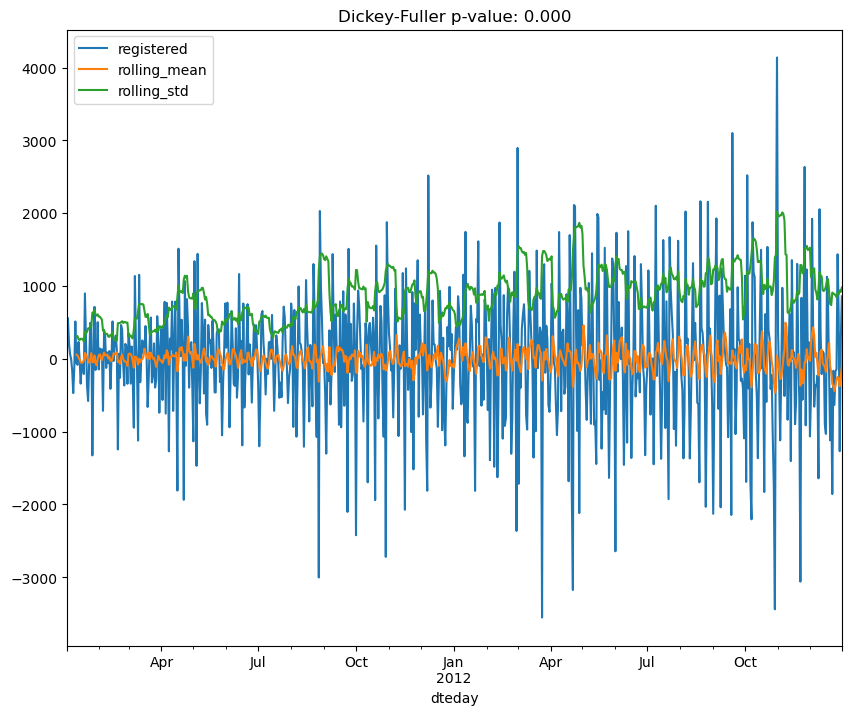

In [79]:
# subtract last value
registered = daily_rides["registered"]
registered_diff = registered - registered.shift()
registered_diff.dropna(inplace=True)
casual = daily_rides["casual"]
casual_diff = casual - casual.shift()
casual_diff.dropna(inplace=True)
plt.figure()
test_stationarity(registered_diff, figsize=(10, 8))

<Figure size 640x480 with 0 Axes>

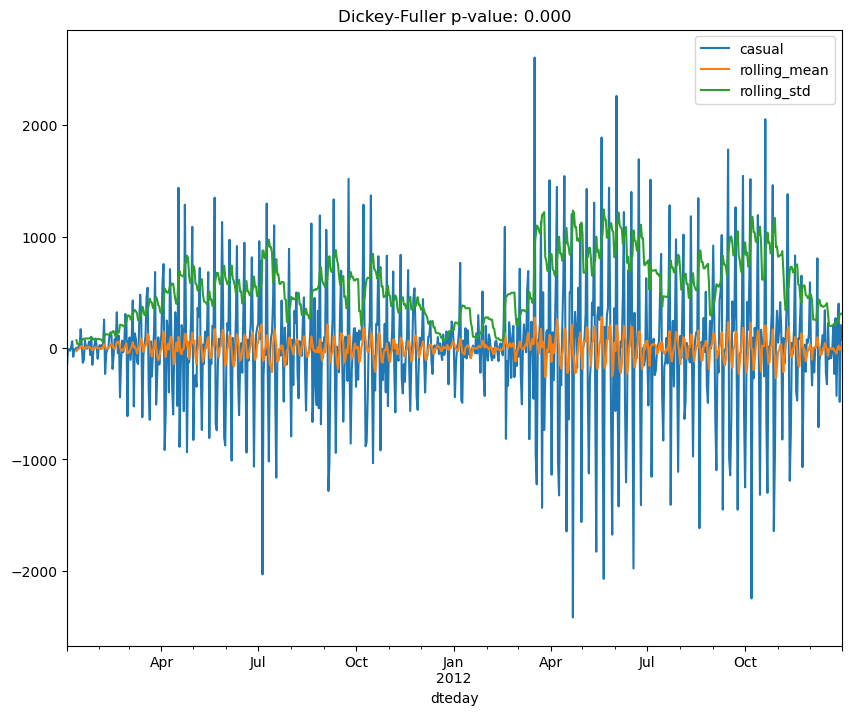

In [81]:
plt.figure()
test_stationarity(casual_diff, figsize=(10, 8))

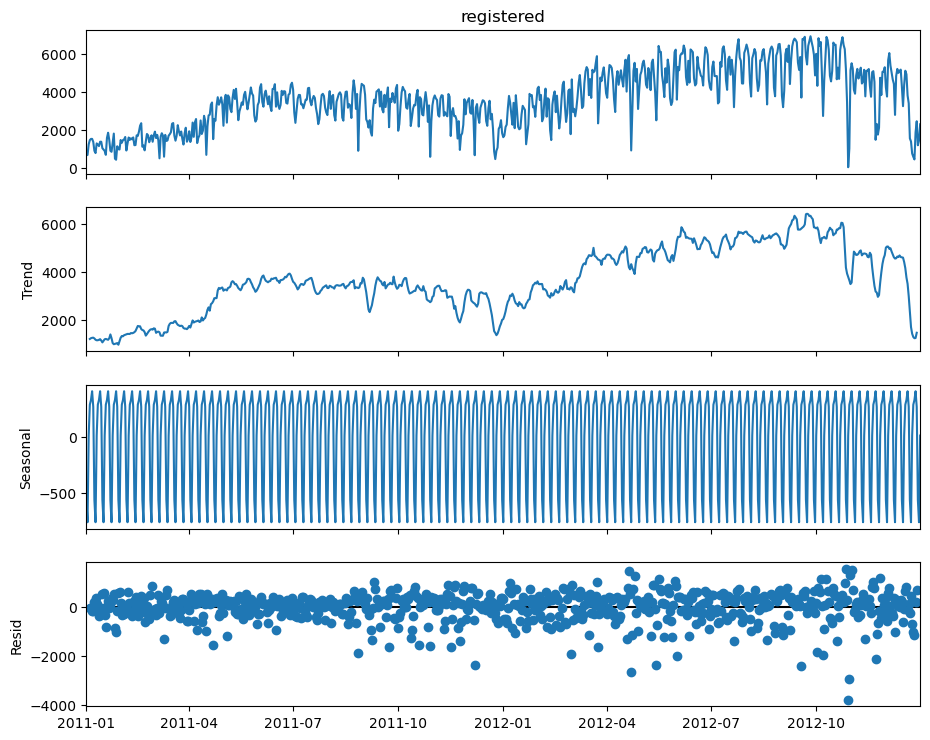

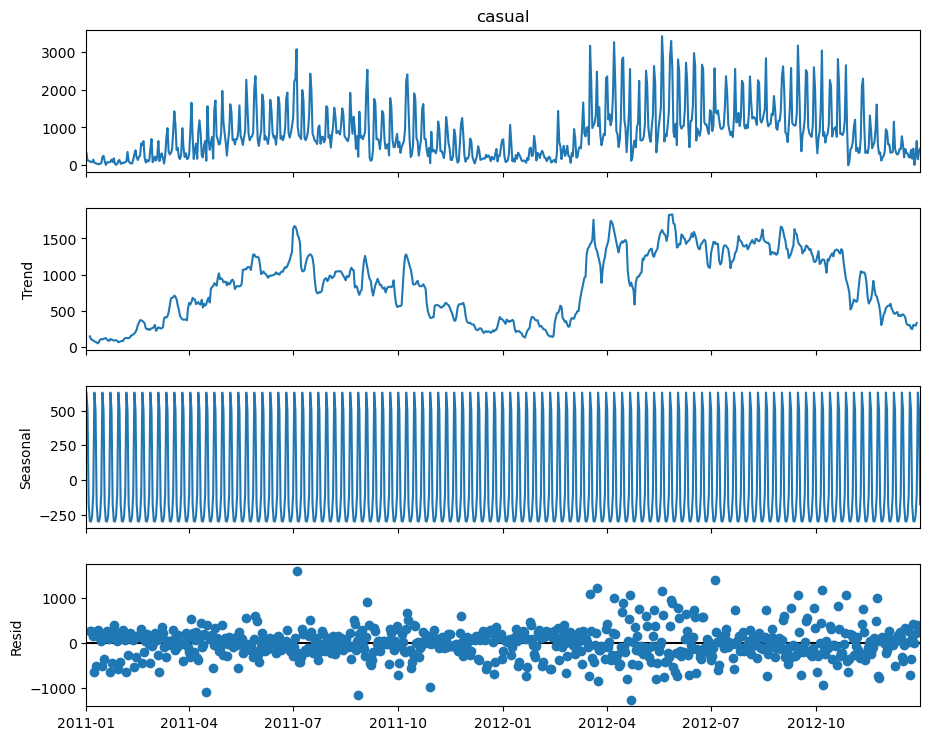

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
registered_decomposition = seasonal_decompose(\
daily_rides["registered"])
casual_decomposition = seasonal_decompose(daily_rides["casual"])

# plot decompositions
registered_plot = registered_decomposition.plot()
registered_plot.set_size_inches(10, 8)
casual_plot = casual_decomposition.plot()
casual_plot.set_size_inches(10, 8)

<Figure size 640x480 with 0 Axes>

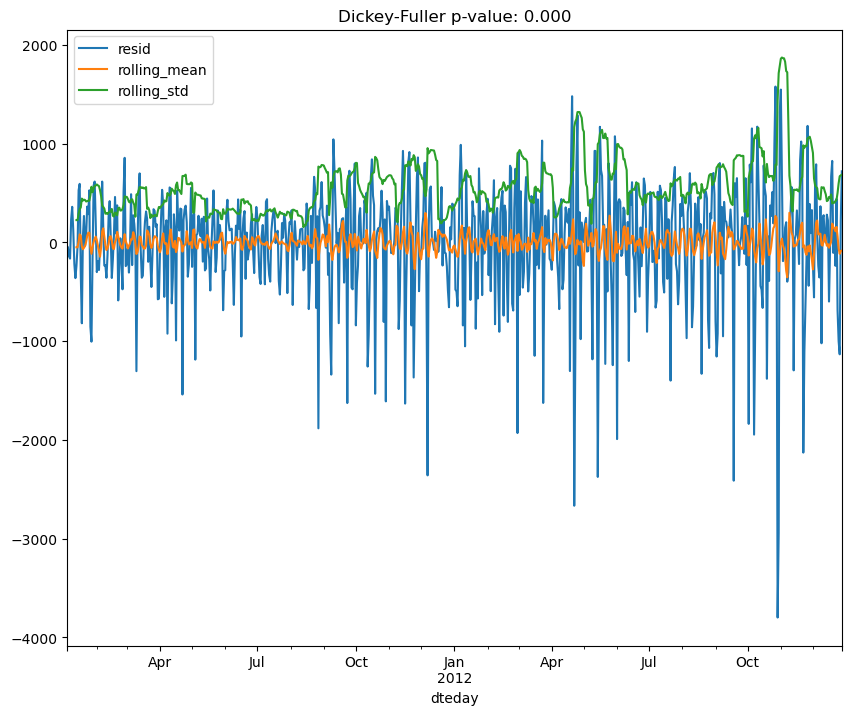

<Figure size 640x480 with 0 Axes>

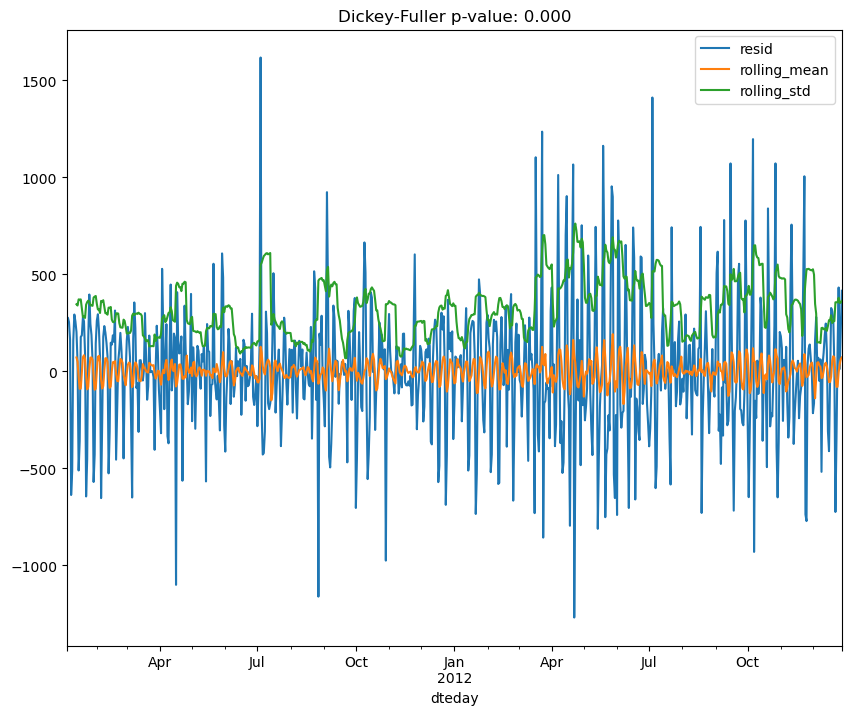

In [84]:
# test residuals for stationarity
plt.figure()
test_stationarity(registered_decomposition.resid.dropna(), \
figsize=(10, 8))
plt.figure()
test_stationarity(casual_decomposition.resid.dropna(), \
figsize=(10, 8))


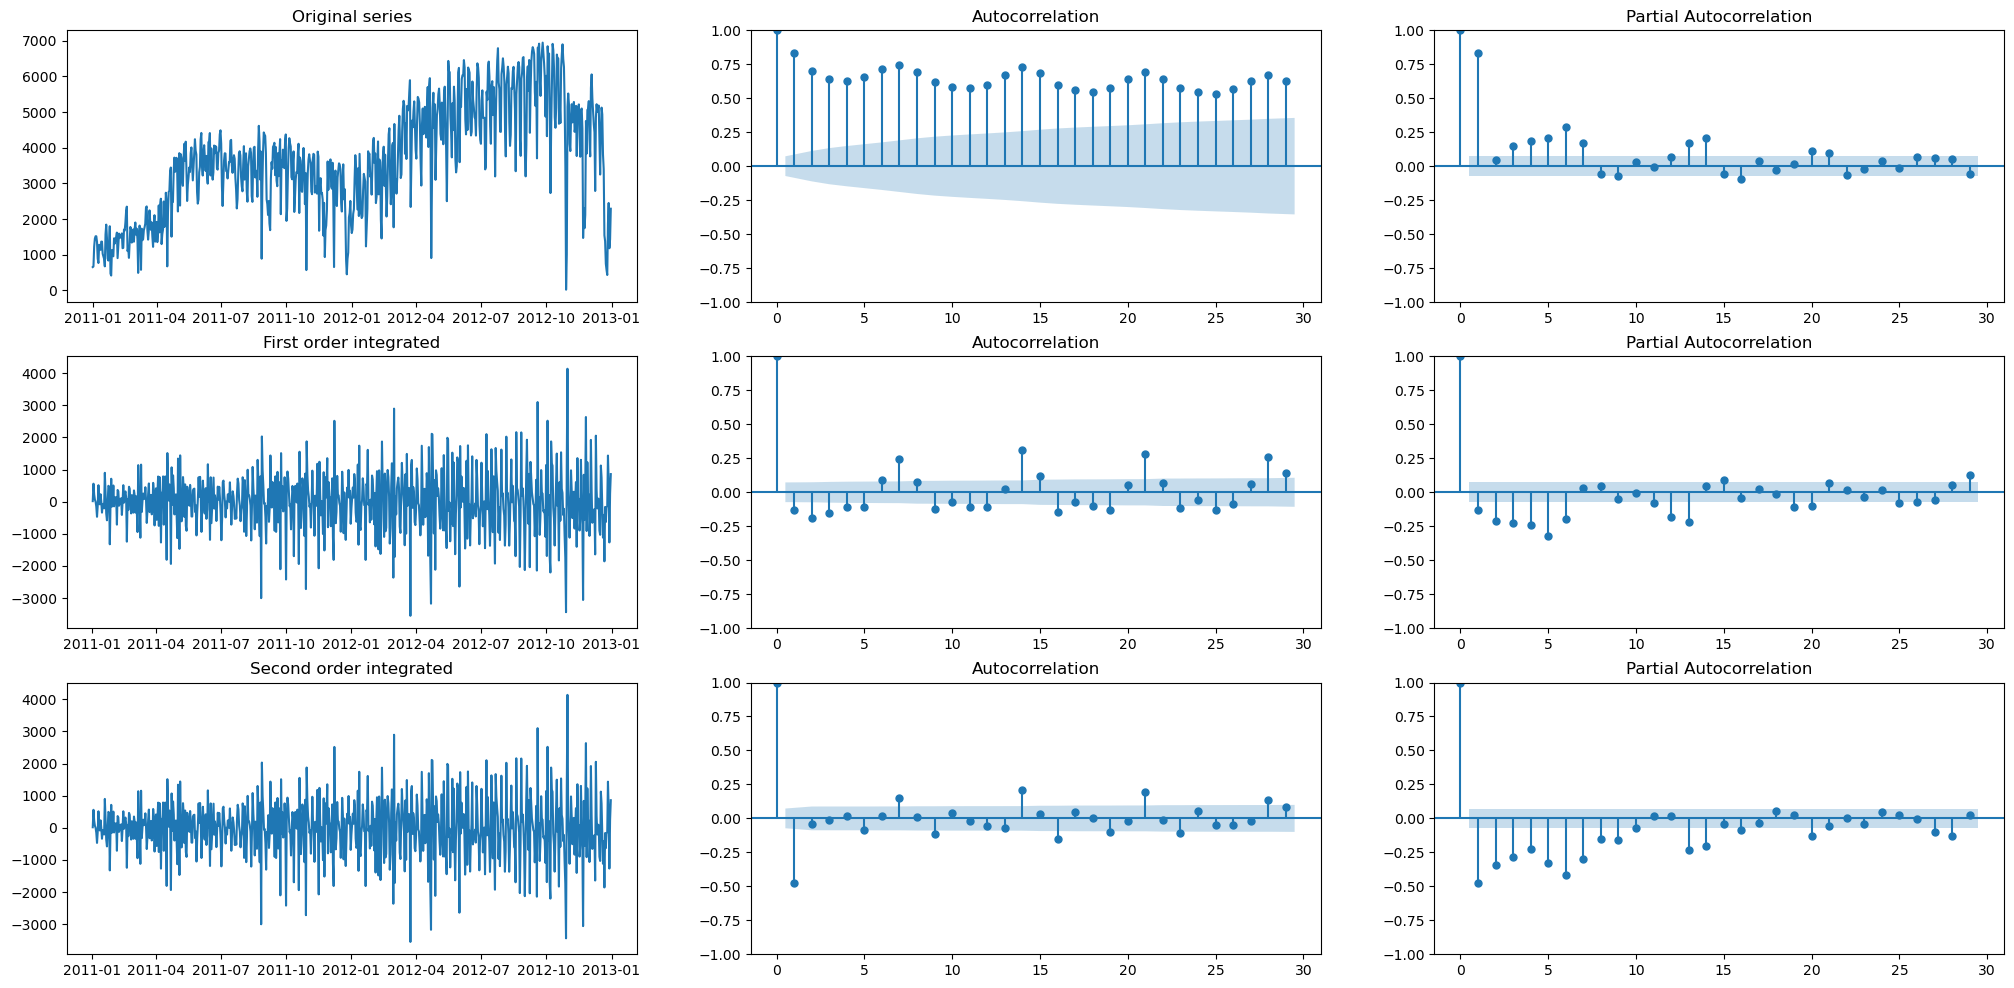

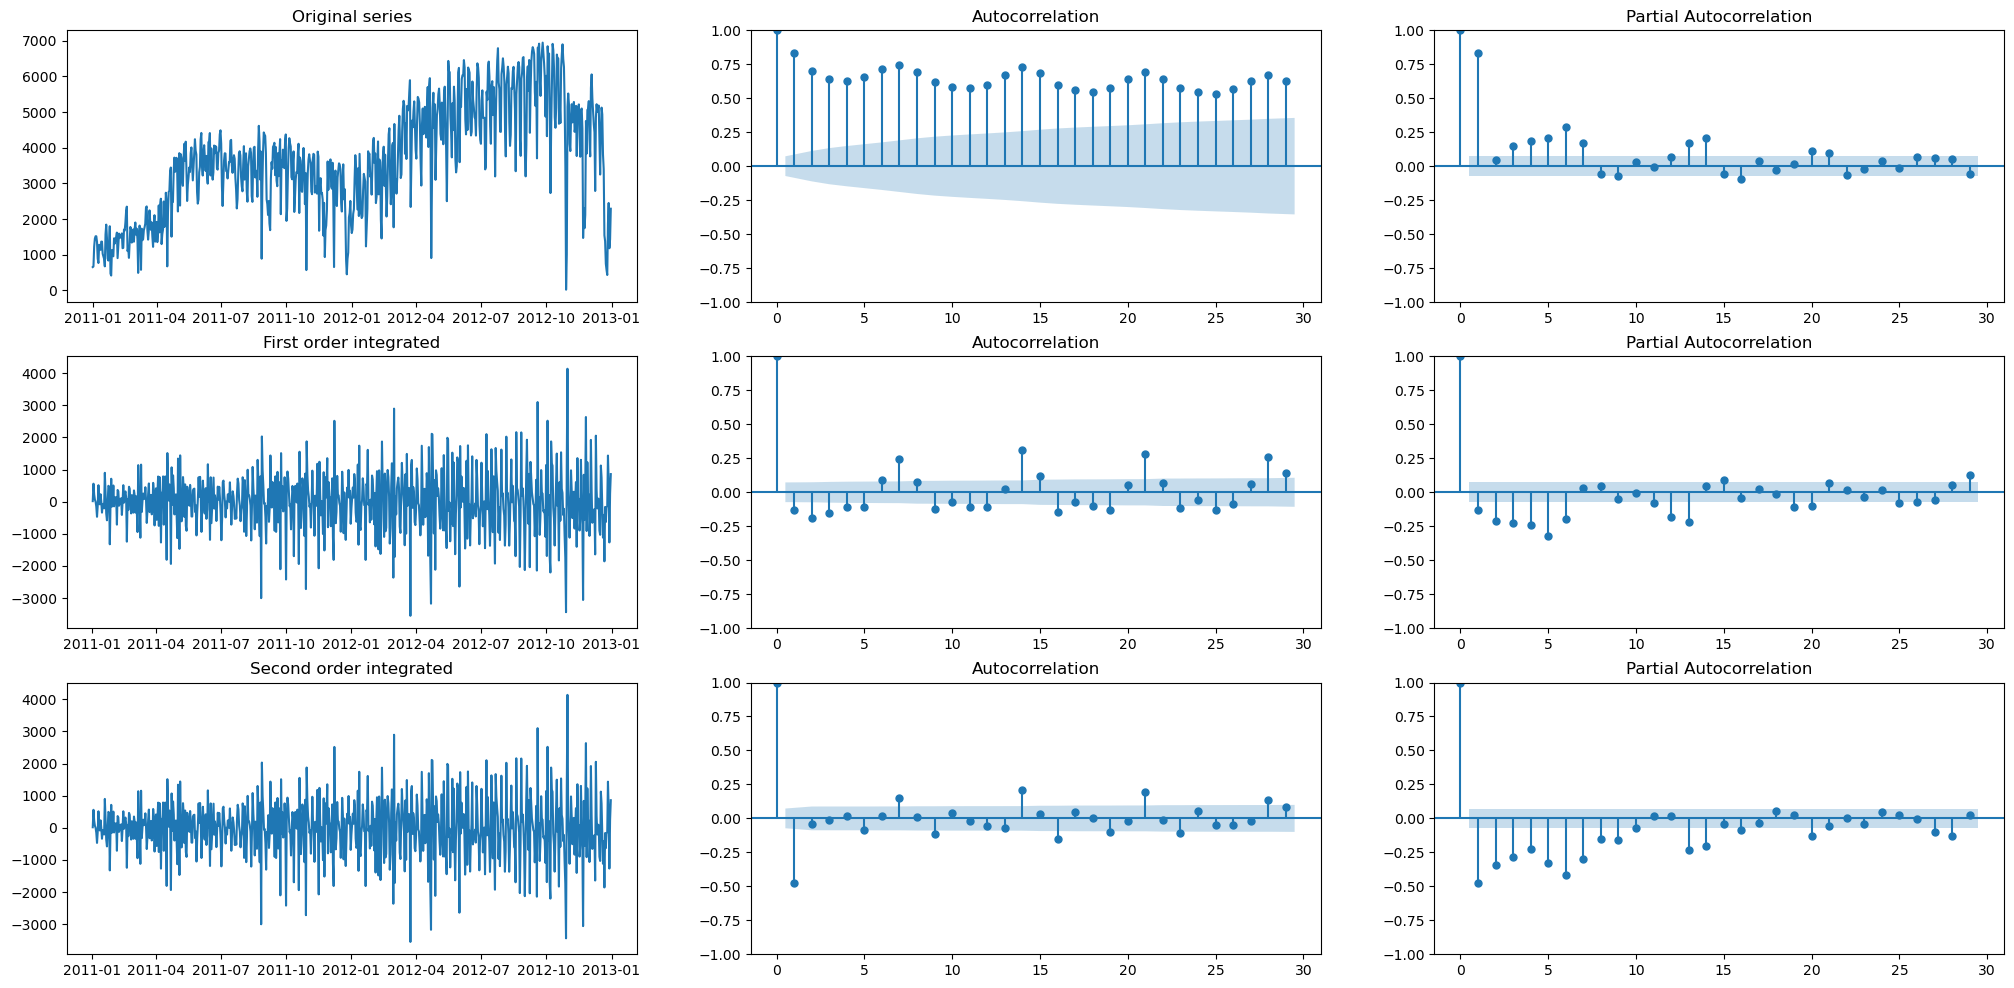

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 3, figsize=(25, 12))
# plot original series
original = daily_rides["registered"]
axes[0,0].plot(original)
axes[0,0].set_title("Original series")
plot_acf(original, ax=axes[0,1])
plot_pacf(original, ax=axes[0,2])
# plot first order integrated series
first_order_int = original.diff().dropna()
axes[1,0].plot(first_order_int)
axes[1,0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1,1])
plot_pacf(first_order_int, ax=axes[1,2])
# plot first order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2,0].plot(first_order_int)
axes[2,0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2,1])
plot_pacf(second_order_int, ax=axes[2,2])

In [86]:
from pmdarima import auto_arima
model = auto_arima(registered, start_p=1, start_q=1, \
max_p=3, max_q=3, information_criterion="aic")
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5854.536
Date:                Fri, 10 Jan 2025   AIC                          11723.072
Time:                        17:52:05   BIC                          11755.223
Sample:                    01-01-2011   HQIC                         11735.476
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6079      0.050     32.264      0.000       1.510       1.706
ar.L2         -1.4478      0.062    -23.260      0.000      -1.570      -1.326
ar.L3          0.3611      0.049      7.367      0.0

Text(0.5, 1.0, 'Predicted vs actual number of rides')

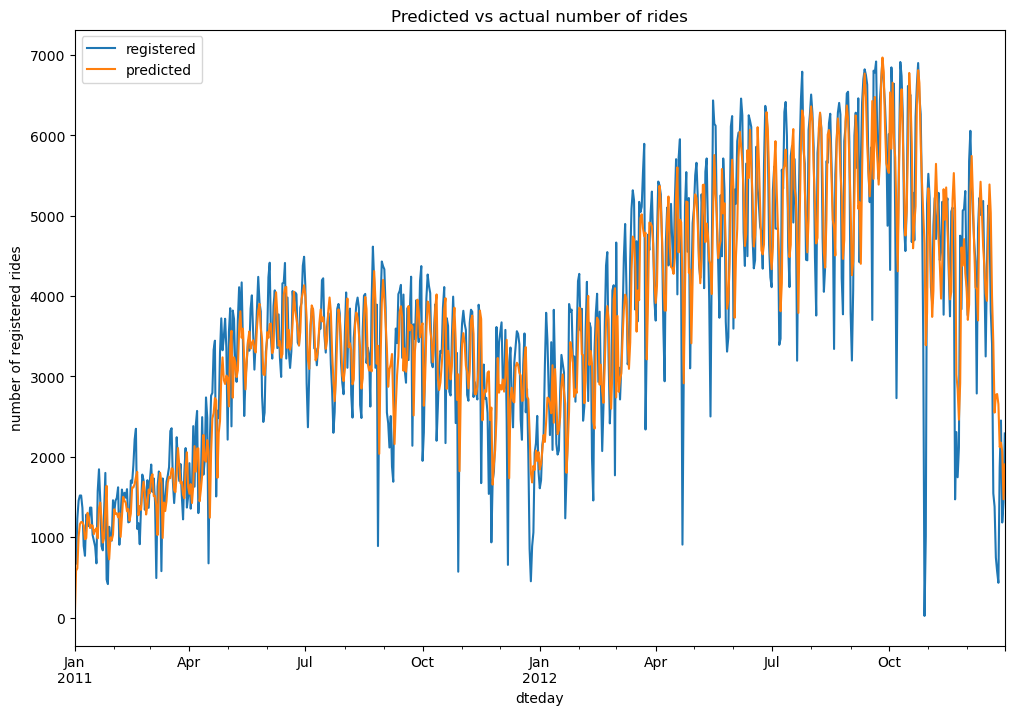

In [87]:
# plot original and predicted values
plot_data = pd.DataFrame(registered)
plot_data['predicted'] = model.predict_in_sample()
plot_data.plot(figsize=(12, 8))
plt.ylabel("number of registered rides")
plt.title("Predicted vs actual number of rides")